In [159]:
PATH = "/media/maxine/c8f4bcb2-c1fe-4676-877d-8e476418f5e5/0-RPE-cell-timelapse/"
import sys
sys.path.append("..")

from modules.learning.models import *

# from modules.learning.evaluate import Evaluation, get_latent_space, plot_umap
from matplotlib import pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# enet = EfficientNet()

track_path = PATH + "track_datasets/control_mm/train/images/"
# track_path_drug = "/media/maxine/c8f4bcb2-c1fe-4676-877d-8e476418f5e5/0-RPE-cell-timelapse/datasets/mTOR/images/"
label_path = PATH + "track_datasets/control_mm/train/labels/"
# label_path_drug = "/media/maxine/c8f4bcb2-c1fe-4676-877d-8e476418f5e5/0-RPE-cell-timelapse/datasets/mTOR/labels/"

import itertools
in_channels = [1]

In [2]:
import matplotlib.pyplot as plt
from dtaidistance import dtw, dtw_ndim, dtw_ndim_visualisation, dtw_visualisation

# loading data

In [102]:
dd = {"a": 9, "b": 1}

for i in dd.keys():
    print(i)
    print(dd[i])

a
9
b
1


In [103]:
import os
cells = os.listdir(label_path)[:]

tracks = {}

for cell in cells:
    track = np.load(label_path + cell).squeeze().T
    tracks[cell] = track

In [110]:
# for name, track in tracks.items():
#     print(name, track.shape)

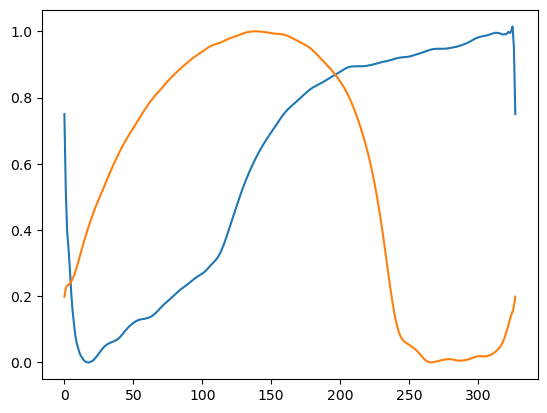

In [111]:
from helper_fn import *

ref_length = 328

fourier = np.load("coef_fourier.npy")

tau_ref = np.linspace(0, 1, ref_length)
btr = vanilla_fn(tau_ref, coeffs=fourier)

plt.plot(btr)

In [112]:
# concatenate tau_ref with itself alonf the axis=1
v = np.concatenate((tau_ref.reshape(-1, 1), tau_ref.reshape(-1, 1)), axis=1)
class_ref = phase2class(v)
durations_ref = class_duration(class_ref)
hours_ref = durations_ref * 5 / 60

## tuning the warping parameters

In [155]:
# random track name among cells
track_name = np.random.choice(list(tracks.keys()))
track_name

'0611.733.npy'

reference_len 604
0 601
track_len 302
0 300
Track's warping too short!
FIXED!


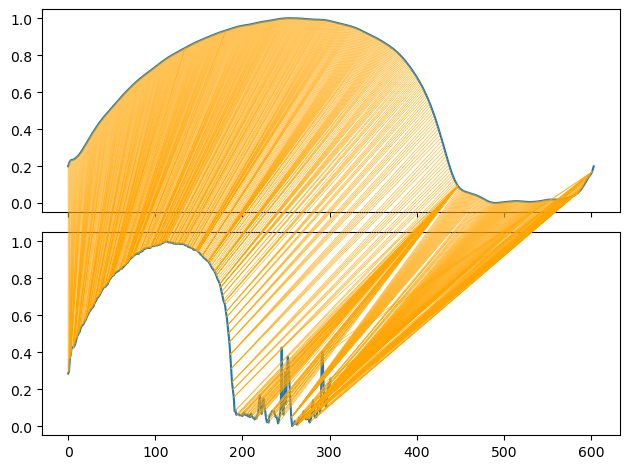

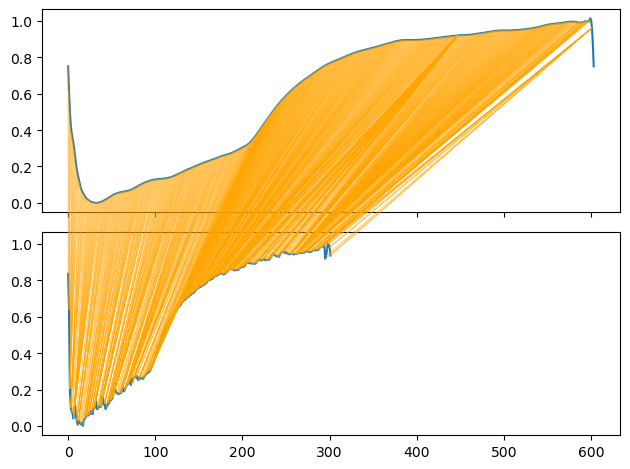

Text(0.5, 0, 'time')

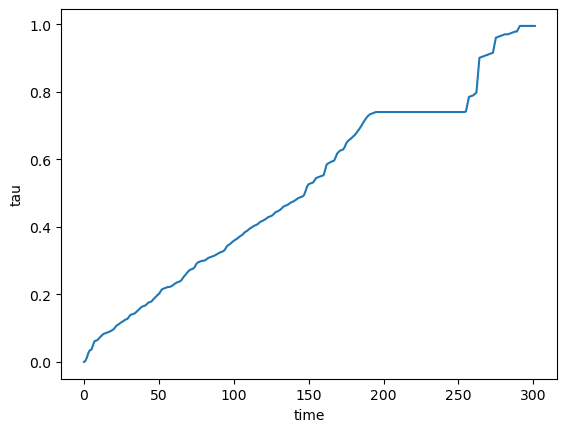

In [156]:
track_name = np.random.choice(list(tracks.keys()))
# track_name = 4516

len_factor = 2
track0 = tracks[track_name]
track0 = track0[:]
tr_len, ref_len = track0.shape[0], track0.shape[0] * len_factor
tau = np.linspace(0, 1, ref_len)
btr = vanilla_fn(tau, coeffs=fourier)

# x = np.load(track_path + cells[track_name], allow_pickle=True)

window_size = None
penalty = None
# despite setting these values to zero I ge still problems that require a dirty fix
psi = (ref_len // 4, ref_len // 4, 0 , 0)
# psi=(0, 0, 0 , 0)

d, wpath = dtw_ndim.warping_paths(btr, track0, window=window_size, penalty=penalty, psi=psi)
best_path = np.array(dtw.best_path(wpath))

len_warped_track = np.unique(best_path[:, 1]).shape[0]

print("reference_len", ref_len)
print(best_path[:, 0].min(), best_path[:,0].max())
print("track_len", tr_len)
print(best_path[:, 1].min(), best_path[:,1].max())

if len_warped_track < tr_len:
    print("Track's warping too short!")
    # take last element of the warped
    last_match = best_path[-1, :]
    # append it to array: (n,2) -> (n+1, 2)
    best_path = np.vstack((best_path, last_match))
    # map last (previously skipped) element of the track to the last element of the reference
    best_path[-1, 1] += 1
    # than increase by one the last elemnt of track

# update length of the warped track
len_warped_track = np.unique(best_path[:, 1]).shape[0]

if len_warped_track < tr_len:
    print("Track's warping STILL too short!")
elif len_warped_track == tr_len:
    print("FIXED!")

elif len_warped_track == tr_len:
    print("Track's warping is GOOD \n")


dtw_visualisation.plot_warping(btr[:, 1], track0[:, 1], best_path)
dtw_visualisation.plot_warping(btr[:, 0], track0[:, 0], best_path)
plt.show()

out = phase_map(best_path, ref_len)
plt.plot(out)
plt.ylabel("tau")
plt.xlabel("time")
    

In [164]:
# tracks.values()

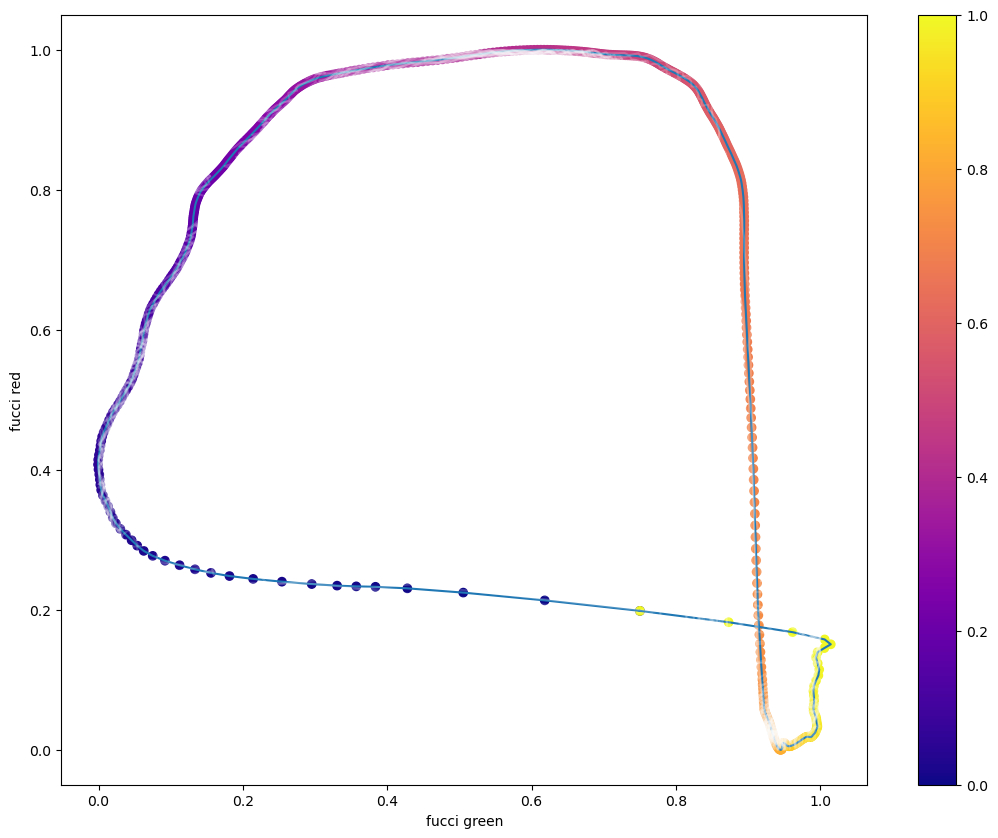

In [165]:
# plot and color with time
plt.figure(figsize=(13, 10))

plt.plot(btr[:, 0], btr[:, 1], label="ref")
plt.scatter(btr[:, 0] , btr[:, 1], c=tau, cmap="plasma")

for tr in list(tracks.values())[:30]:
    plt.plot(tr[:, 0], tr[:, 1], alpha=0.2, color="white") 

plt.xlabel("fucci green")
plt.ylabel("fucci red")
plt.colorbar()

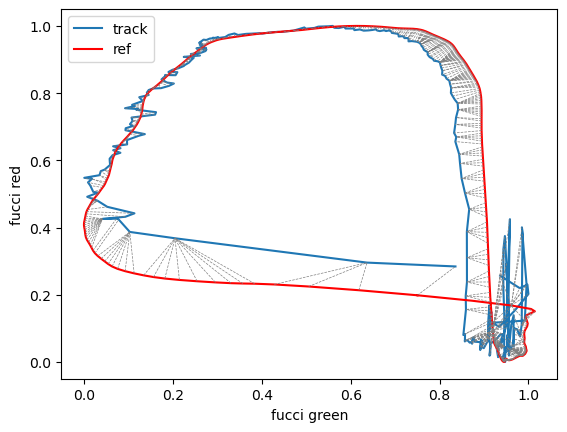

In [166]:
plt.plot(track0[:, 0], track0[:, 1], label="track")
plt.plot(btr[:, 0], btr[:, 1], label="ref", color="red")

for i, j in best_path:
    plt.plot(
        [btr[i, 0], track0[j, 0]],  # btr first, track0 second
        [btr[i, 1], track0[j, 1]],
        color="gray",
        linestyle="--",
        linewidth=0.5,
    )

plt.xlabel("fucci green")
plt.ylabel("fucci red")
plt.legend()

In [92]:
import stackview
stackview.slice(x, zoom_factor=4)

# running on all tracks

In [167]:
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

len_factor = 2
window_size = None
penalty = None


In [170]:
def process_track(args):
    name, track, len_factor, fourier, window_size, penalty = args
    tr_len, ref_len = track.shape[0], track.shape[0] * len_factor
    tau = np.linspace(0, 1, ref_len)
    btr = vanilla_fn(tau, coeffs=fourier)
    
    psi = (ref_len // 2, ref_len // 2, 0, 0)
    d, wpath = dtw_ndim.warping_paths(btr, track, window=window_size, penalty=penalty, psi=psi)
    best_path = np.array(dtw.best_path(wpath))

    len_warped_track = np.unique(best_path[:, 1]).shape[0]
        
    if len_warped_track < tr_len:
        # take last element of the warped
        last_match = best_path[-1, :]
        # append it to array: (n,2) -> (n+1, 2)
        best_path = np.vstack((best_path, last_match))
        # map last (previously skipped) element of the track to the last element of the reference
        best_path[-1, 1] += 1
        # than increase by one the last elemnt of track

    # update length of the warped track
    len_warped_track = np.unique(best_path[:, 1]).shape[0]

    if len_warped_track < tr_len:
        print("Track's warping too short!")
    
    out = phase_map(best_path, ref_len)
    return name, best_path, out

args = [(name, track, len_factor, fourier, window_size, penalty) for name, track in tracks.items()]

best_paths = {}
phases = {}
with ProcessPoolExecutor() as executor:
    for result in tqdm(executor.map(process_track, args), total=len(tracks)):
        name, best_path, out = result  # Unpack the two outputs
        best_paths[name] = best_path  # Save best_path
        phases[name] = out 


100%|██████████| 5188/5188 [06:16<00:00, 13.79it/s]


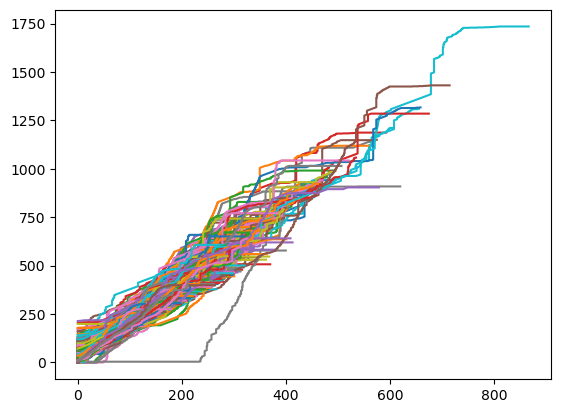

In [172]:
for key, best_path in best_paths.items():
    # tru, out = phase_map(best_path, ref_len)
    plt.plot(best_path[:, 1], best_path[:, 0])

In [ ]:
# save phases list in GT folder

np.save("GT_warping_phases/paths.npy", best_paths)
np.save("GT_warping_phases/phases.npy", phases)

Text(0, 0.5, 'phase')

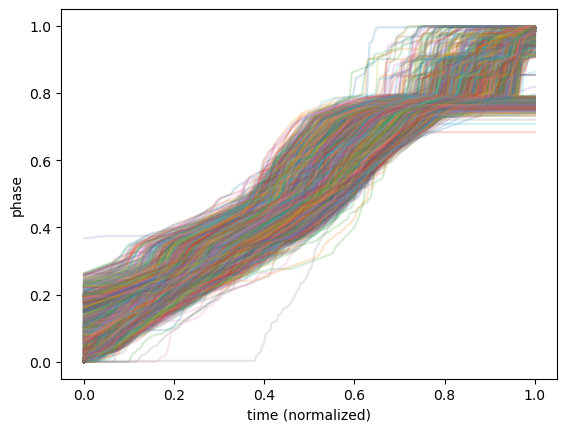

In [176]:
for key, ph in phases.items():
    # tru, out = phase_map(best_path, ref_len)
    tau = np.linspace(0, 1, len(ph))
    plt.plot(tau, ph, alpha=0.2)

plt.xlabel("time (normalized)")
plt.ylabel("phase")